In [2]:
# train_improved.py
import pandas as pd
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from math import sqrt

# -------------------------------
# 1. Load Dataset
# -------------------------------
print("Loading dataset...")
df = pd.read_csv("digital_diet_mental_health.csv")
print(f"Dataset shape: {df.shape}")

# -------------------------------
# 2. Rule-based Risk Label
# -------------------------------
def assign_risk_rule(row):
    if row["stress_level"] > 7 or row["sleep_duration_hours"] < 5:
        return "High"
    elif row["stress_level"] < 4 and row["sleep_duration_hours"] >= 7:
        return "Low"
    else:
        return "Medium"

df["risk_level"] = df.apply(assign_risk_rule, axis=1)

# -------------------------------
# 3. Features for Classifier
# -------------------------------
clf_features = [
    "daily_screen_time_hours",
    "sleep_duration_hours",
    "stress_level",
    "sleep_quality",
    "physical_activity_hours_per_week"
]

# Save deterministic classifier artifacts
scaler_clf = StandardScaler()
X_clf = scaler_clf.fit_transform(df[clf_features])
y_clf = df["risk_level"]

joblib.dump(scaler_clf, "scaler_clf.pkl")
# We don’t train ML model here → just keep rule-based classifier
print("✅ Classifier will use rule-based risk rules (not ML).")

# -------------------------------
# 4. Regression (Mood Rating)
# -------------------------------
print("\nTraining nonlinear regressor...")

# Feature engineering
df["screen_sleep_ratio"] = df["daily_screen_time_hours"] / (df["sleep_duration_hours"] + 1)
df["stress_x_sleep"] = df["stress_level"] * df["sleep_quality"]
df["activity_balance"] = df["physical_activity_hours_per_week"] / (df["daily_screen_time_hours"] + 1)

reg_features = clf_features + ["screen_sleep_ratio", "stress_x_sleep", "activity_balance"]
X_reg = df[reg_features]
y_reg = df["mood_rating"]

scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

reg_model = RandomForestRegressor(n_estimators=200, random_state=42)
reg_model.fit(X_reg_scaled, y_reg)

# Evaluate
y_pred_reg = reg_model.predict(X_reg_scaled)
mae = mean_absolute_error(y_reg, y_pred_reg)
rmse = sqrt(mean_squared_error(y_reg, y_pred_reg))

print(f"Regression MAE: {mae:.3f}")
print(f"Regression RMSE: {rmse:.3f}")

joblib.dump(reg_model, "mood_model.pkl")
joblib.dump(scaler_reg, "scaler_reg.pkl")

# -------------------------------
# 5. Clustering
# -------------------------------
print("\nClustering experiments...")
cluster_features = ["social_media_hours", "gaming_hours", "entertainment_hours", "work_related_hours"]
X_cluster = df[cluster_features]

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

best_model = None
best_score = -1
best_method = ""

# Try KMeans (2–6 clusters)
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster_scaled)
    score = silhouette_score(X_cluster_scaled, labels)
    print(f"KMeans k={k} → silhouette {score:.3f}")
    if score > best_score:
        best_score = score
        best_model = km
        best_method = f"KMeans(k={k})"

# Try Gaussian Mixture
gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(X_cluster_scaled)
score = silhouette_score(X_cluster_scaled, labels)
print(f"GMM (3 comps) → silhouette {score:.3f}")
if score > best_score:
    best_score = score
    best_model = gmm
    best_method = "GaussianMixture(3)"

# Try DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=10)
labels = dbscan.fit_predict(X_cluster_scaled)
if len(set(labels)) > 1 and -1 not in set(labels):  # only valid if >1 cluster and no noise
    score = silhouette_score(X_cluster_scaled, labels)
    print(f"DBSCAN → silhouette {score:.3f}")
    if score > best_score:
        best_score = score
        best_model = dbscan
        best_method = "DBSCAN"

print(f"\n✅ Best clustering method: {best_method} (silhouette={best_score:.3f})")

joblib.dump(best_model, "cluster_model.pkl")
joblib.dump(scaler_cluster, "scaler_cluster.pkl")

# -------------------------------
# 6. Save Feature Lists
# -------------------------------
artifacts = {
    "clf_features": clf_features,
    "reg_features": reg_features,
    "cluster_features": cluster_features,
    "best_cluster_method": best_method
}
joblib.dump(artifacts, "artifacts.pkl")

print("\n✅ Improved models and scalers saved successfully!")


Loading dataset...
Dataset shape: (2000, 25)
✅ Classifier will use rule-based risk rules (not ML).

Training nonlinear regressor...
Regression MAE: 0.955
Regression RMSE: 1.122

Clustering experiments...
KMeans k=2 → silhouette 0.175
KMeans k=3 → silhouette 0.169
KMeans k=4 → silhouette 0.173
KMeans k=5 → silhouette 0.178
KMeans k=6 → silhouette 0.176
GMM (3 comps) → silhouette 0.133

✅ Best clustering method: KMeans(k=5) (silhouette=0.178)

✅ Improved models and scalers saved successfully!


In [5]:
# test_improved.py
import pandas as pd
import joblib
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, silhouette_score
from math import sqrt
import numpy as np

print("Loading artifacts...")
artifacts = joblib.load("artifacts.pkl")

clf_features = artifacts["clf_features"]
reg_features = artifacts["reg_features"]
cluster_features = artifacts["cluster_features"]
best_cluster_method = artifacts["best_cluster_method"]

print("Expected features loaded:")
print("Classifier:", clf_features)
print("Regressor:", reg_features)
print("Clustering:", cluster_features, "→", best_cluster_method)

# -------------------------------
# Load Models & Scalers
# -------------------------------
scaler_clf = joblib.load("scaler_clf.pkl")
regression_model = joblib.load("mood_model.pkl")
scaler_reg = joblib.load("scaler_reg.pkl")
clustering_model = joblib.load("cluster_model.pkl")
scaler_cluster = joblib.load("scaler_cluster.pkl")

# -------------------------------
# Rule-based Classifier Function
# -------------------------------
def assign_risk_rule(row):
    if row["stress_level"] > 7 or row["sleep_duration_hours"] < 5:
        return "High"
    elif row["stress_level"] < 4 and row["sleep_duration_hours"] >= 7:
        return "Low"
    else:
        return "Medium"

# -------------------------------
# Feature Engineering (same as training)
# -------------------------------
def add_regression_features(df):
    df = df.copy()
    df["screen_sleep_ratio"] = df["daily_screen_time_hours"] / (df["sleep_duration_hours"] + 1e-3)
    df["stress_x_sleep"] = df["stress_level"] * df["sleep_quality"]
    df["activity_balance"] = df["physical_activity_hours_per_week"] / (df["daily_screen_time_hours"] + 1e-3)
    return df

# -------------------------------
# 1. Single Sample Test
# -------------------------------
sample_user = pd.DataFrame({
    "daily_screen_time_hours": [6],
    "sleep_duration_hours": [7],
    "stress_level": [5],
    "sleep_quality": [6],
    "physical_activity_hours_per_week": [3],
    "social_media_hours": [3],
    "gaming_hours": [2],
    "entertainment_hours": [2],
    "work_related_hours": [3]
})

print("\n--- Single Sample Test ---")
risk_pred = assign_risk_rule(sample_user.iloc[0])
print(f"Predicted Risk Level: {risk_pred}")

# Add engineered features before regression
sample_user_reg = add_regression_features(sample_user)
X_reg = scaler_reg.transform(sample_user_reg[reg_features])
mood_pred = regression_model.predict(X_reg)[0]
print(f"Predicted Mood Rating: {mood_pred:.2f}")

X_cluster = scaler_cluster.transform(sample_user[cluster_features])
cluster_pred = clustering_model.predict(X_cluster)[0]
print(f"Predicted Usage Cluster: {cluster_pred}")

# -------------------------------
# 2. Batch Test on Subset
# -------------------------------
print("\n--- Batch Test (random subset) ---")
df = pd.read_csv("digital_diet_mental_health.csv")
df["risk_level"] = df.apply(assign_risk_rule, axis=1)

# Add regression features to dataset
df = add_regression_features(df)

df_sample = df.sample(400, random_state=42)

# Classifier evaluation
y_true = df_sample["risk_level"]
y_pred = df_sample.apply(assign_risk_rule, axis=1)
print("\nClassification report:")
print(classification_report(y_true, y_pred))

# Regression evaluation
X_reg_test = scaler_reg.transform(df_sample[reg_features])
y_pred_reg = regression_model.predict(X_reg_test)
mae = mean_absolute_error(df_sample["mood_rating"], y_pred_reg)
rmse = sqrt(mean_squared_error(df_sample["mood_rating"], y_pred_reg))
print(f"Regression MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# Clustering evaluation
X_cluster_test = scaler_cluster.transform(df_sample[cluster_features])
labels = clustering_model.predict(X_cluster_test)
unique, counts = np.unique(labels, return_counts=True)
print("Cluster distribution:", dict(zip(unique, counts)))

# Silhouette score
if len(np.unique(labels)) > 1:  # avoid error if only 1 cluster
    sil_score = silhouette_score(X_cluster_test, labels)
    print(f"Clustering Silhouette Score: {sil_score:.3f}")
else:
    print("Silhouette score skipped (only 1 cluster detected).")

print("\n✅ All tests completed.")


Loading artifacts...
Expected features loaded:
Classifier: ['daily_screen_time_hours', 'sleep_duration_hours', 'stress_level', 'sleep_quality', 'physical_activity_hours_per_week']
Regressor: ['daily_screen_time_hours', 'sleep_duration_hours', 'stress_level', 'sleep_quality', 'physical_activity_hours_per_week', 'screen_sleep_ratio', 'stress_x_sleep', 'activity_balance']
Clustering: ['social_media_hours', 'gaming_hours', 'entertainment_hours', 'work_related_hours'] → KMeans(k=5)

--- Single Sample Test ---
Predicted Risk Level: Medium
Predicted Mood Rating: 5.69
Predicted Usage Cluster: 1

--- Batch Test (random subset) ---

Classification report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       152
         Low       1.00      1.00      1.00        50
      Medium       1.00      1.00      1.00       198

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1

In [3]:
# user_friendly_test.py
import pandas as pd
import joblib
from math import sqrt
import numpy as np

# Load artifacts
artifacts = joblib.load("artifacts.pkl")
clf_features = artifacts["clf_features"]
reg_features = artifacts["reg_features"]
cluster_features = artifacts["cluster_features"]

scaler_clf = joblib.load("scaler_clf.pkl")
scaler_reg = joblib.load("scaler_reg.pkl")
reg_model = joblib.load("mood_model.pkl")
scaler_cluster = joblib.load("scaler_cluster.pkl")
cluster_model = joblib.load("cluster_model.pkl")

# Rule-based risk
def assign_risk_rule(row):
    if row["stress_level"] > 7 or row["sleep_duration_hours"] < 5:
        return "High"
    elif row["stress_level"] < 4 and row["sleep_duration_hours"] >= 7:
        return "Low"
    else:
        return "Medium"

# Collect user input
print("Enter your daily habits for prediction:")
daily_screen_time = float(input("Daily screen time (hours): "))
sleep_hours = float(input("Sleep duration (hours): "))
stress_level = float(input("Stress level (0–10): "))
sleep_quality = float(input("Sleep quality (0–10): "))
physical_activity = float(input("Physical activity per week (hours): "))
social_hours = float(input("Social media usage (hours): "))
gaming_hours = float(input("Gaming hours: "))
entertainment_hours = float(input("Entertainment hours: "))
work_hours = float(input("Work-related screen time (hours): "))

# Build DataFrame
user_df = pd.DataFrame([{
    "daily_screen_time_hours": daily_screen_time,
    "sleep_duration_hours": sleep_hours,
    "stress_level": stress_level,
    "sleep_quality": sleep_quality,
    "physical_activity_hours_per_week": physical_activity,
    "social_media_hours": social_hours,
    "gaming_hours": gaming_hours,
    "entertainment_hours": entertainment_hours,
    "work_related_hours": work_hours
}])

# Engineer features for regression
user_df["screen_sleep_ratio"] = user_df["daily_screen_time_hours"] / (user_df["sleep_duration_hours"] + 1)
user_df["stress_x_sleep"] = user_df["stress_level"] * user_df["sleep_quality"]
user_df["activity_balance"] = user_df["physical_activity_hours_per_week"] / (user_df["daily_screen_time_hours"] + 1)

# Predict Risk
risk = assign_risk_rule(user_df.iloc[0])

# Predict Mood
X_reg = scaler_reg.transform(user_df[reg_features])
mood_pred = reg_model.predict(X_reg)[0]

# Predict Cluster
X_cluster = scaler_cluster.transform(user_df[cluster_features])
cluster_pred = cluster_model.predict(X_cluster)[0]

# Output
print("\n--- Prediction Results ---")
print(f"Risk Level: {risk}")
print(f"Predicted Mood Rating: {mood_pred:.2f} / 10")
print(f"Predicted Usage Cluster: {cluster_pred}")


Enter your daily habits for prediction:

--- Prediction Results ---
Risk Level: Low
Predicted Mood Rating: 5.97 / 10
Predicted Usage Cluster: 4


<Axes: >

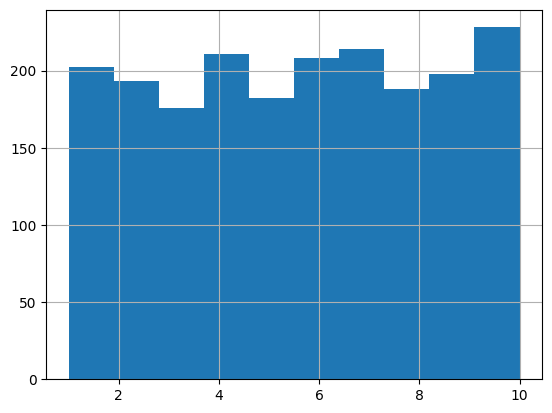

In [4]:
df["mood_rating"].describe()
df["mood_rating"].hist()
